In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Data

In [2]:
df = pd.read_csv('data/data/daily_min_temp.csv', index_col = 'Date', parse_dates= ['Date'])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


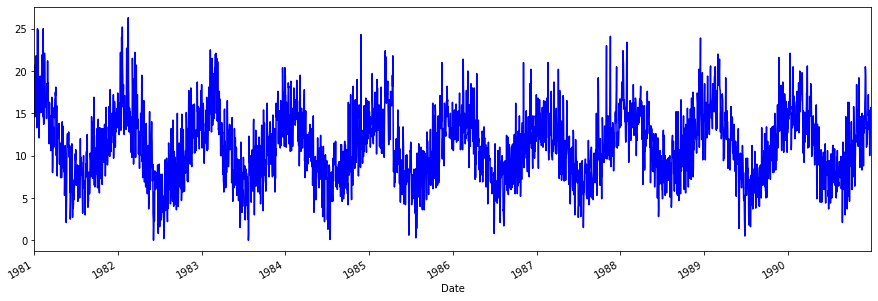

In [3]:
df.Temp.plot(figsize = (15, 5), color = 'b')

# Dataset Splitting

In [4]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle = False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

# Dataset and Dataloader

In [5]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import TensorDataset, DataLoader

In [6]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, 'Temp', seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, 'Temp', seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



# Architecture & Configuration

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout = dropout, batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc (x)
        return x, hidden

In [8]:
config = set_config({
    'input_size': train_set.n_feature,
    'seq_len': train_set.n_seq,
    'hidden_size': 64,
    'num_layers': 2,
    'dropout': 0,
    'output_size': 1,    
})

# Training Preparation

In [11]:
model = LSTM(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/lstm")

# Training

In [12]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 136.0201 | Test_cost  = 137.8185 | 




Epoch     2
Train_cost  = 123.6415 | Test_cost  = 120.1174 | 




Epoch     3
Train_cost  = 103.5999 | Test_cost  = 97.0422 | 




Epoch     4
Train_cost  = 82.2287 | Test_cost  = 76.8756 | 




Epoch     5
Train_cost  = 64.5044 | Test_cost  = 60.9629 | 




Epoch     6
Train_cost  = 51.3424 | Test_cost  = 50.1244 | 




Epoch     7
Train_cost  = 42.7820 | Test_cost  = 43.0044 | 




Epoch     8
Train_cost  = 36.9978 | Test_cost  = 37.8111 | 




Epoch     9
Train_cost  = 32.7097 | Test_cost  = 33.7891 | 




Epoch    10
Train_cost  = 29.3898 | Test_cost  = 30.6009 | 




Epoch    11
Train_cost  = 26.7817 | Test_cost  = 28.0549 | 




Epoch    12
Train_cost  = 24.7268 | Test_cost  = 26.0190 | 




Epoch    13
Train_cost  = 23.1103 | Test_cost  = 24.3931 | 




Epoch    14
Train_cost  = 21.8434 | Test_cost  = 23.0975 | 




Epoch    15
Train_cost  = 20.8546 | Test_cost  = 22.0676 | 




Epoch    16
Train_cost  = 20.0861 | Test_cost  = 21.2503 | 




Epoch    17
Train_cost  = 19.4905 | Test_cost  = 20.6025 | 




Epoch    18
Train_cost  = 19.0295 | Test_cost  = 20.0885 | 




Epoch    19
Train_cost  = 18.6722 | Test_cost  = 19.6799 | 




Epoch    20
Train_cost  = 18.3941 | Test_cost  = 19.3537 | 


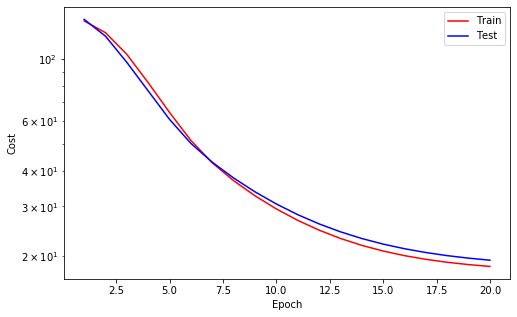



Epoch    21
Train_cost  = 18.1760 | Test_cost  = 19.0918 | 




Epoch    22
Train_cost  = 18.0030 | Test_cost  = 18.8798 | 




Epoch    23
Train_cost  = 17.8638 | Test_cost  = 18.7068 | 




Epoch    24
Train_cost  = 17.7500 | Test_cost  = 18.5643 | 




Epoch    25
Train_cost  = 17.6554 | Test_cost  = 18.4457 | 




Epoch    26
Train_cost  = 17.5754 | Test_cost  = 18.3460 | 




Epoch    27
Train_cost  = 17.5067 | Test_cost  = 18.2615 | 




Epoch    28
Train_cost  = 17.4468 | Test_cost  = 18.1892 | 




Epoch    29
Train_cost  = 17.3941 | Test_cost  = 18.1268 | 




Epoch    30
Train_cost  = 17.3472 | Test_cost  = 18.0725 | 




Epoch    31
Train_cost  = 17.3051 | Test_cost  = 18.0249 | 




Epoch    32
Train_cost  = 17.2672 | Test_cost  = 17.9829 | 




Epoch    33
Train_cost  = 17.2329 | Test_cost  = 17.9456 | 




Epoch    34
Train_cost  = 17.2016 | Test_cost  = 17.9122 | 




Epoch    35
Train_cost  = 17.1731 | Test_cost  = 17.8823 | 




Epoch    36
Train_cost  = 17.1471 | Test_cost  = 17.8552 | 




Epoch    37
Train_cost  = 17.1232 | Test_cost  = 17.8306 | 




Epoch    38
Train_cost  = 17.1012 | Test_cost  = 17.8082 | 




Epoch    39
Train_cost  = 17.0809 | Test_cost  = 17.7876 | 




Epoch    40
Train_cost  = 17.0621 | Test_cost  = 17.7687 | 


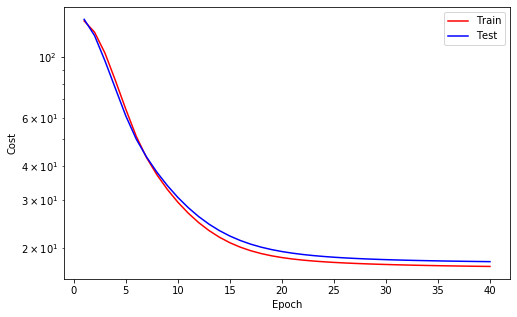



Epoch    41
Train_cost  = 17.0448 | Test_cost  = 17.7513 | 




Epoch    42
Train_cost  = 17.0286 | Test_cost  = 17.7352 | 




Epoch    43
Train_cost  = 17.0137 | Test_cost  = 17.7202 | 




Epoch    44
Train_cost  = 16.9997 | Test_cost  = 17.7062 | 




Epoch    45
Train_cost  = 16.9866 | Test_cost  = 17.6932 | 




Epoch    46
Train_cost  = 16.9744 | Test_cost  = 17.6810 | 




Epoch    47
Train_cost  = 16.9629 | Test_cost  = 17.6695 | 




Epoch    48
Train_cost  = 16.9521 | Test_cost  = 17.6587 | 




Epoch    49
Train_cost  = 16.9419 | Test_cost  = 17.6485 | 




Epoch    50
Train_cost  = 16.9322 | Test_cost  = 17.6389 | 




Epoch    51
Train_cost  = 16.9229 | Test_cost  = 17.6294 | 




Epoch    52
Train_cost  = 16.9133 | Test_cost  = 17.6188 | 




Epoch    53
Train_cost  = 16.9031 | Test_cost  = 17.6100 | 




Epoch    54
Train_cost  = 16.8950 | Test_cost  = 17.6022 | 




Epoch    55
Train_cost  = 16.8874 | Test_cost  = 17.5945 | 




Epoch    56
Train_cost  = 16.8800 | Test_cost  = 17.5870 | 




Epoch    57
Train_cost  = 16.8728 | Test_cost  = 17.5797 | 




Epoch    58
Train_cost  = 16.8659 | Test_cost  = 17.5727 | 




Epoch    59
Train_cost  = 16.8592 | Test_cost  = 17.5661 | 




Epoch    60
Train_cost  = 16.8528 | Test_cost  = 17.5598 | 


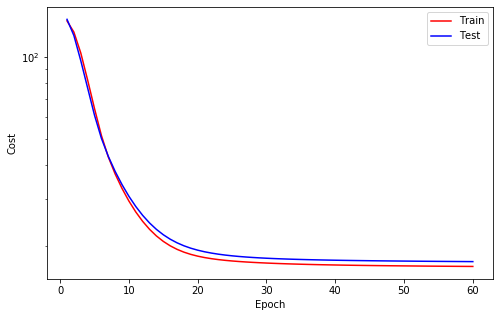



Epoch    61
Train_cost  = 16.8464 | Test_cost  = 17.5532 | 




Epoch    62
Train_cost  = 16.8385 | Test_cost  = 17.5437 | 




Epoch    63
Train_cost  = 16.8299 | Test_cost  = 17.5373 | 




Epoch    64
Train_cost  = 16.8225 | Test_cost  = 17.5290 | 




Epoch    65
Train_cost  = 16.8137 | Test_cost  = 17.5201 | 




Epoch    66
Train_cost  = 16.8053 | Test_cost  = 17.5124 | 




Epoch    67
Train_cost  = 16.7974 | Test_cost  = 17.5039 | 




Epoch    68
Train_cost  = 16.7884 | Test_cost  = 17.4939 | 




Epoch    69
Train_cost  = 16.7778 | Test_cost  = 17.4819 | 




Epoch    70
Train_cost  = 16.7651 | Test_cost  = 17.4672 | 




Epoch    71
Train_cost  = 16.7492 | Test_cost  = 17.4482 | 




Epoch    72
Train_cost  = 16.7269 | Test_cost  = 17.4176 | 




Epoch    73
Train_cost  = 16.6859 | Test_cost  = 17.3425 | 




Epoch    74
Train_cost  = 16.5711 | Test_cost  = 17.1627 | 




Epoch    75
Train_cost  = 16.3974 | Test_cost  = 17.0529 | 




Epoch    76
Train_cost  = 16.3055 | Test_cost  = 16.9403 | 




Epoch    77
Train_cost  = 16.1716 | Test_cost  = 16.7284 | 




Epoch    78
Train_cost  = 15.9051 | Test_cost  = 16.2287 | 




Epoch    79
Train_cost  = 15.2399 | Test_cost  = 15.0645 | 




Epoch    80
Train_cost  = 13.8862 | Test_cost  = 13.6768 | 


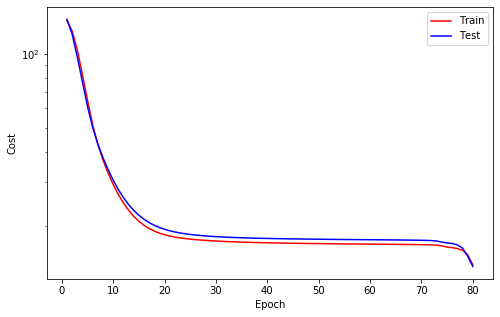



Epoch    81
Train_cost  = 12.5724 | Test_cost  = 12.7185 | 




Epoch    82
Train_cost  = 11.9608 | Test_cost  = 11.6664 | 




Epoch    83
Train_cost  = 11.1199 | Test_cost  = 10.8678 | 




Epoch    84
Train_cost  = 10.4464 | Test_cost  = 10.2369 | 




Epoch    85
Train_cost  = 9.9466 | Test_cost  = 9.6929 | 




Epoch    86
Train_cost  = 9.4648 | Test_cost  = 9.1824 | 




Epoch    87
Train_cost  = 9.1167 | Test_cost  = 8.8075 | 




Epoch    88
Train_cost  = 8.8260 | Test_cost  = 8.4111 | 




Epoch    89
Train_cost  = 8.5376 | Test_cost  = 8.1467 | 




Epoch    90
Train_cost  = 8.3421 | Test_cost  = 7.8636 | 




Epoch    91
Train_cost  = 8.1539 | Test_cost  = 7.6526 | 




Epoch    92
Train_cost  = 7.9888 | Test_cost  = 7.4492 | 




Epoch    93
Train_cost  = 7.8401 | Test_cost  = 7.3018 | 




Epoch    94
Train_cost  = 7.7284 | Test_cost  = 7.1518 | 




Epoch    95
Train_cost  = 7.6232 | Test_cost  = 7.0315 | 




Epoch    96
Train_cost  = 7.5334 | Test_cost  = 6.9156 | 




Epoch    97
Train_cost  = 7.4497 | Test_cost  = 6.8205 | 




Epoch    98
Train_cost  = 7.3781 | Test_cost  = 6.7334 | 




Epoch    99
Train_cost  = 7.3141 | Test_cost  = 6.6574 | 




Epoch   100
Train_cost  = 7.2559 | Test_cost  = 6.5888 | 


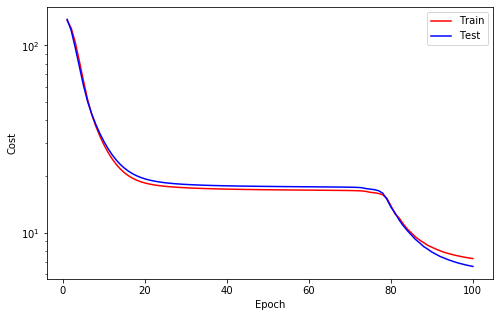



Epoch   101
Train_cost  = 7.2036 | Test_cost  = 6.5263 | 




Epoch   102
Train_cost  = 7.1554 | Test_cost  = 6.4696 | 




Epoch   103
Train_cost  = 7.1125 | Test_cost  = 6.4166 | 




Epoch   104
Train_cost  = 7.0729 | Test_cost  = 6.3679 | 




Epoch   105
Train_cost  = 7.0366 | Test_cost  = 6.3220 | 




Epoch   106
Train_cost  = 7.0024 | Test_cost  = 6.2792 | 




Epoch   107
Train_cost  = 6.9707 | Test_cost  = 6.2390 | 




Epoch   108
Train_cost  = 6.9408 | Test_cost  = 6.2014 | 




Epoch   109
Train_cost  = 6.9127 | Test_cost  = 6.1658 | 




Epoch   110
Train_cost  = 6.8859 | Test_cost  = 6.1323 | 




Epoch   111
Train_cost  = 6.8606 | Test_cost  = 6.1002 | 




Epoch   112
Train_cost  = 6.8362 | Test_cost  = 6.0696 | 




Epoch   113
Train_cost  = 6.8128 | Test_cost  = 6.0403 | 




Epoch   114
Train_cost  = 6.7903 | Test_cost  = 6.0123 | 




Epoch   115
Train_cost  = 6.7685 | Test_cost  = 5.9855 | 




Epoch   116
Train_cost  = 6.7475 | Test_cost  = 5.9598 | 




Epoch   117
Train_cost  = 6.7271 | Test_cost  = 5.9353 | 




Epoch   118
Train_cost  = 6.7073 | Test_cost  = 5.9119 | 




Epoch   119
Train_cost  = 6.6881 | Test_cost  = 5.8895 | 




Epoch   120
Train_cost  = 6.6694 | Test_cost  = 5.8682 | 


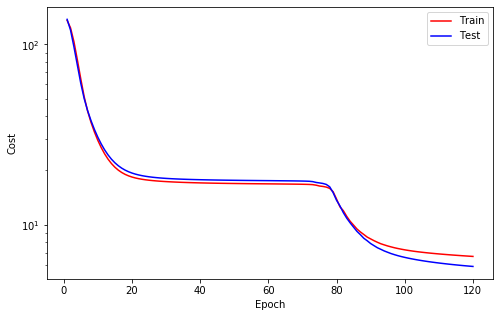



Epoch   121
Train_cost  = 6.6511 | Test_cost  = 5.8477 | 




Epoch   122
Train_cost  = 6.6333 | Test_cost  = 5.8281 | 




Epoch   123
Train_cost  = 6.6158 | Test_cost  = 5.8091 | 




Epoch   124
Train_cost  = 6.5986 | Test_cost  = 5.7907 | 




Epoch   125
Train_cost  = 6.5817 | Test_cost  = 5.7727 | 




Epoch   126
Train_cost  = 6.5651 | Test_cost  = 5.7551 | 




Epoch   127
Train_cost  = 6.5488 | Test_cost  = 5.7379 | 




Epoch   128
Train_cost  = 6.5329 | Test_cost  = 5.7211 | 




Epoch   129
Train_cost  = 6.5174 | Test_cost  = 5.7048 | 




Epoch   130
Train_cost  = 6.5023 | Test_cost  = 5.6890 | 




Epoch   131
Train_cost  = 6.4878 | Test_cost  = 5.6739 | 




Epoch   132
Train_cost  = 6.4740 | Test_cost  = 5.6594 | 




Epoch   133
Train_cost  = 6.4608 | Test_cost  = 5.6458 | 




Epoch   134
Train_cost  = 6.4483 | Test_cost  = 5.6328 | 




Epoch   135
Train_cost  = 6.4364 | Test_cost  = 5.6204 | 




Epoch   136
Train_cost  = 6.4250 | Test_cost  = 5.6087 | 




Epoch   137
Train_cost  = 6.4141 | Test_cost  = 5.5977 | 




Epoch   138
Train_cost  = 6.4036 | Test_cost  = 5.5872 | 




Epoch   139
Train_cost  = 6.3934 | Test_cost  = 5.5775 | 




Epoch   140
Train_cost  = 6.3835 | Test_cost  = 5.5687 | 


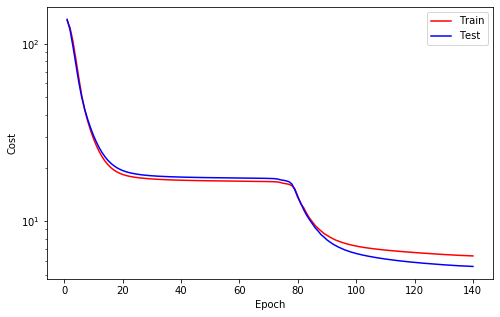



Epoch   141
Train_cost  = 6.3738 | Test_cost  = 5.5607 | 




Epoch   142
Train_cost  = 6.3644 | Test_cost  = 5.5535 | 




Epoch   143
Train_cost  = 6.3550 | Test_cost  = 5.5471 | 




Epoch   144
Train_cost  = 6.3456 | Test_cost  = 5.5409 | 




Epoch   145
Train_cost  = 6.3360 | Test_cost  = 5.5345 | 




Epoch   146
Train_cost  = 6.3261 | Test_cost  = 5.5272 | 




Epoch   147
Train_cost  = 6.3159 | Test_cost  = 5.5189 | 




Epoch   148
Train_cost  = 6.3055 | Test_cost  = 5.5097 | 




Epoch   149
Train_cost  = 6.2952 | Test_cost  = 5.5001 | 




Epoch   150
Train_cost  = 6.2853 | Test_cost  = 5.4909 | 




Epoch   151
Train_cost  = 6.2760 | Test_cost  = 5.4822 | 




Epoch   152
Train_cost  = 6.2673 | Test_cost  = 5.4743 | 




Epoch   153
Train_cost  = 6.2591 | Test_cost  = 5.4671 | 




Epoch   154
Train_cost  = 6.2513 | Test_cost  = 5.4605 | 




Epoch   155
Train_cost  = 6.2438 | Test_cost  = 5.4545 | 




Epoch   156
Train_cost  = 6.2364 | Test_cost  = 5.4489 | 




Epoch   157
Train_cost  = 6.2293 | Test_cost  = 5.4439 | 




Epoch   158
Train_cost  = 6.2222 | Test_cost  = 5.4395 | 




Epoch   159
Train_cost  = 6.2154 | Test_cost  = 5.4358 | 




Epoch   160
Train_cost  = 6.2087 | Test_cost  = 5.4328 | 


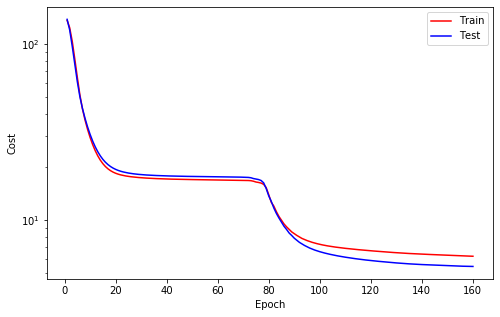



Epoch   161
Train_cost  = 6.2022 | Test_cost  = 5.4308 | 




Epoch   162
Train_cost  = 6.1960 | Test_cost  = 5.4299 | 




Epoch   163
Train_cost  = 6.1900 | Test_cost  = 5.4303 | 
==> EarlyStop patience =  1 | Best test_cost: 5.4299




Epoch   164
Train_cost  = 6.1842 | Test_cost  = 5.4322 | 
==> EarlyStop patience =  2 | Best test_cost: 5.4299




Epoch   165
Train_cost  = 6.1785 | Test_cost  = 5.4352 | 
==> EarlyStop patience =  3 | Best test_cost: 5.4299




Epoch   166
Train_cost  = 6.1724 | Test_cost  = 5.4384 | 
==> EarlyStop patience =  4 | Best test_cost: 5.4299




Epoch   167
Train_cost  = 6.1657 | Test_cost  = 5.4400 | 
==> EarlyStop patience =  5 | Best test_cost: 5.4299
==> Execute Early Stopping at epoch: 167 | Best test_cost: 5.4299
==> Best model is saved at model/lstm


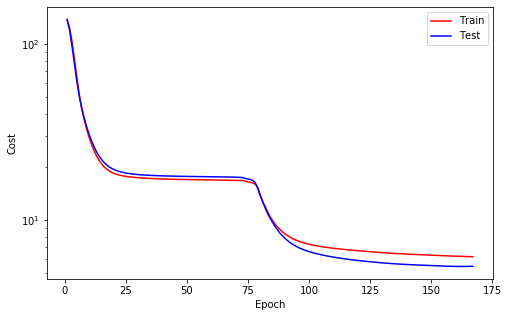

In [13]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Sanity Check

In [14]:
from utils import data4pred, pred4pred

In [15]:
train_forecast_set = TimeSeriesDataset(ts_train, 'Temp', 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, 'Temp', 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Train')

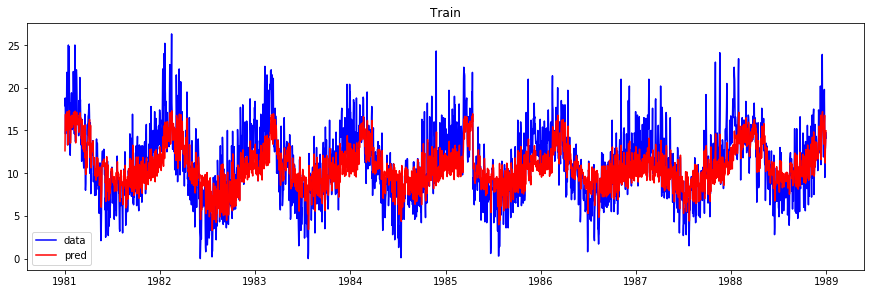

In [16]:
plt.figure(figsize =(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title('Train')


Text(0.5, 1.0, 'Test')

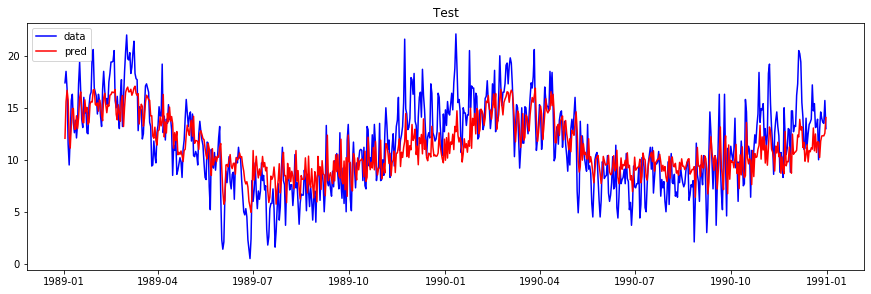

In [17]:
plt.figure(figsize =(15, 10))
plt.subplot(211)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')

Text(0.5, 1.0, 'test')

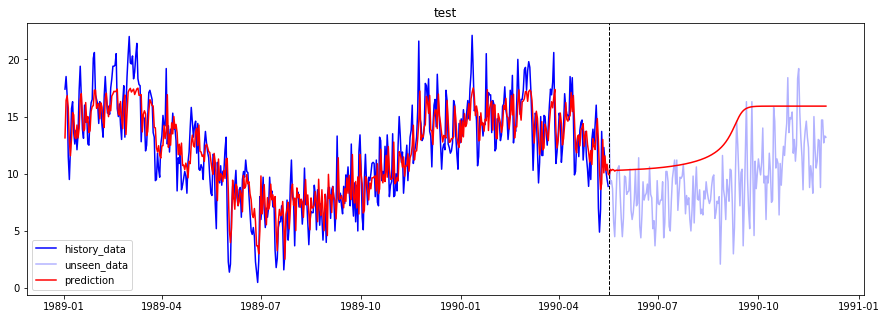

In [75]:
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title('test')